[11:20:35] WARNING: not removing hydrogen atom without neighbors
[11:20:36] WARNING: not removing hydrogen atom without neighbors
[11:20:36] WARNING: not removing hydrogen atom without neighbors
[11:20:36] WARNING: not removing hydrogen atom without neighbors
[11:20:36] WARNING: not removing hydrogen atom without neighbors
[11:20:36] WARNING: not removing hydrogen atom without neighbors
C:\Users\SCDC\anaconda3\envs\pythonProject\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'mp' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['mp'])`.
C:\Users\SCDC\anaconda3\envs\pythonProject\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'ffn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['ffn'])`.
GPU available: False, used: False
TPU available: False, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\SCDC\anaconda3\envs\pythonProject\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\SCDC\anaconda3\envs\pythonProject\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
C:\Users\SCDC\anaconda3\envs\pythonProject\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Binary Accuracy: 0.8250
Binary F1 Score: 0.7942
Precision: 0.8486
Recall: 0.7463


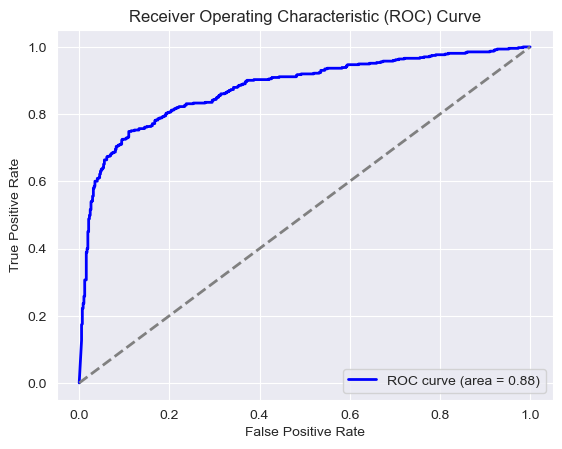

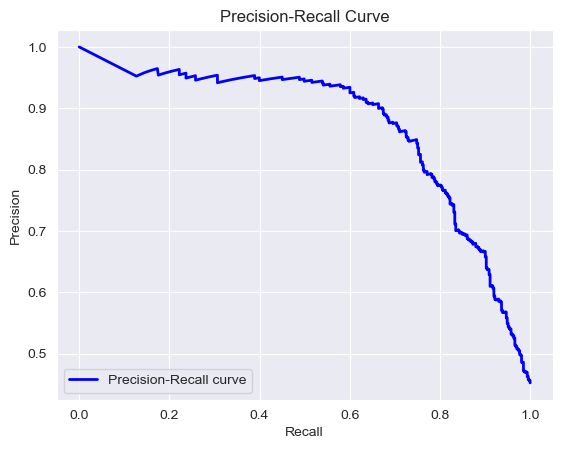

In [10]:
#程序拟合
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
from lightning import pytorch as pl
from chemprop import data, featurizers, models, nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 创建结果文件夹
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# 数据加载
input_path = "smiles_10449_train_test.csv"  # path to your data .csv file
num_workers = 0  # number of workers for dataloader
smiles_column = 'SMILES'  # name of the column containing SMILES strings
target_columns = ['Toxicity']  # classification of activity (either 0 or 1)
df_input = pd.read_csv(input_path)

# 数据预处理
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

# 数据拆分
mols = [d.mol for d in all_data]
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(all_data, train_indices, val_indices, test_indices)

# 特征提取
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
train_dset = data.MoleculeDataset(train_data[0], featurizer)
val_dset = data.MoleculeDataset(val_data[0], featurizer)
test_dset = data.MoleculeDataset(test_data[0], featurizer)
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

# 自定义模型
class MyMPNNModel(models.MPNN):
    def __init__(self, mp, agg, ffn, batch_norm, metric_list):
        super().__init__(mp, agg, ffn, batch_norm, metric_list)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        lr_scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True),
            'monitor': 'val_loss',
            'frequency': 1,
        }
        return {
            'optimizer': optimizer,
            'lr_scheduler': lr_scheduler,
        }

# 模型初始化
mp = nn.BondMessagePassing()
agg = nn.MeanAggregation()
ffn = nn.BinaryClassificationFFN(n_tasks=1)
batch_norm = False
metric_list = None
mpnn = MyMPNNModel(mp, agg, ffn, batch_norm, metric_list)

# 训练设置
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="cpu",
    devices=1,
    max_epochs=20,
    callbacks=[pl.callbacks.ModelCheckpoint(dirpath=results_dir, monitor='val_loss', save_top_k=1)],
)

# 训练模型
trainer.fit(mpnn, train_loader, val_loader)

# 保存最佳模型
best_model_path = os.path.join(results_dir, 'best_model.ckpt')
trainer.save_checkpoint(best_model_path)

# 测试集预测
with torch.inference_mode():
    test_preds = trainer.predict(mpnn, test_loader)

test_preds = np.concatenate([pred.numpy() for pred in test_preds], axis=0)

# 收集测试结果
y_true = df_input.iloc[test_indices[0]][target_columns[0]].values.flatten()
y_pred = test_preds.flatten()

# 二值化预测
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# 计算指标
accuracy = accuracy_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)

# 打印结果
print(f"Binary Accuracy: {accuracy:.4f}")
print(f"Binary F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(results_dir, 'roc_curve.png'))  # 保存ROC曲线图

# 绘制Precision-Recall曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(os.path.join(results_dir, 'precision_recall_curve.png'))  # 保存Precision-Recall曲线图

# 保存测试结果到CSV文件
output_df = pd.DataFrame({
    'SMILES': df_input.iloc[test_indices[0]][smiles_column].values,
    'True_Toxicity': y_true,
    'Predicted_Toxicity': y_pred
})
output_df.to_csv(os.path.join(results_dir, 'test_results.csv'), index=False)


In [25]:
#未知预测
# 加载未知化合物数据
unknown_input_path = "unknown_compounds.csv"  # 你的未知化合物.csv文件路径
unknown_df = pd.read_csv(unknown_input_path)

# 确保SMILES列的名称正确
unknown_smiles_column = 'SMILES'  # 包含SMILES字符串的列名
unknown_smis = unknown_df.loc[:, unknown_smiles_column].values

# 预处理未知化合物数据
unknown_data = [data.MoleculeDatapoint.from_smi(smi, None) for smi in unknown_smis]
unknown_mols = [d.mol for d in unknown_data]
unknown_dset = data.MoleculeDataset(unknown_data, featurizer)
unknown_loader = data.build_dataloader(unknown_dset, num_workers=num_workers, shuffle=False)

# 对未知化合物进行预测
with torch.inference_mode():
    unknown_preds = trainer.predict(mpnn, unknown_loader)

unknown_preds = np.concatenate([pred.numpy() for pred in unknown_preds], axis=0)

# 将预测结果二值化
unknown_preds_binary = [1 if p >= 0.5 else 0 for p in unknown_preds.flatten()]

# 将预测结果保存到CSV文件
unknown_output_df = pd.DataFrame({
    'Compound_Name': unknown_df['Name'],  # 假设你有这一列
    'SMILES': unknown_df[unknown_smiles_column].values,
    'Predicted_Toxicity': unknown_preds_binary
})

unknown_output_df.to_csv(os.path.join(results_dir, 'unknown_predictions.csv'), index=False)

print("未知化合物的预测结果已保存至 'unknown_predictions.csv'.")


C:\Users\SCDC\anaconda3\envs\pythonProject\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

未知化合物的预测结果已保存至 'unknown_predictions.csv'.
